# Modification du Dataset

## Basé sur les résultats de corrélation :
- Supprimer les mots parasites des avis
- Supprimer les avis avec note = 3
- Supprimer les colonnes inutiles : Cloth ID, Age
- Gérer les titres vides (16.2%) et les avis vides (3.6%)
- Conserver Positive Feedback Count (poids important)
- À évaluer : colonnes Division, Department, Name

## Import des Librairies

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import string

## Chargement du Dataset Original

In [96]:
df = pd.read_csv('dataset-customer-review.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")

df.head(10)

Dataset shape: (23486, 11)
Total rows: 23,486
Total columns: 11


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


## Informations sur le Dataset

In [97]:
print("=== COLUMN TYPES ===")
print(df.dtypes)

=== COLUMN TYPES ===
Unnamed: 0                  int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object


## Analyse des Valeurs Manquantes

In [98]:
# Count missing values per column
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Create a summary DataFrame
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Missing %': missing_percentage.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print("=== MISSING VALUES SUMMARY ===")
print(missing_df.to_string(index=False))
print(f"\nTotal rows with at least one missing value: {df.isnull().any(axis=1).sum():,}")
print(f"Percentage: {(df.isnull().any(axis=1).sum() / len(df)) * 100:.2f}%")

=== MISSING VALUES SUMMARY ===
         Column  Missing Count  Missing %
          Title           3810  16.222430
    Review Text            845   3.597888
  Division Name             14   0.059610
Department Name             14   0.059610
     Class Name             14   0.059610

Total rows with at least one missing value: 3,824
Percentage: 16.28%


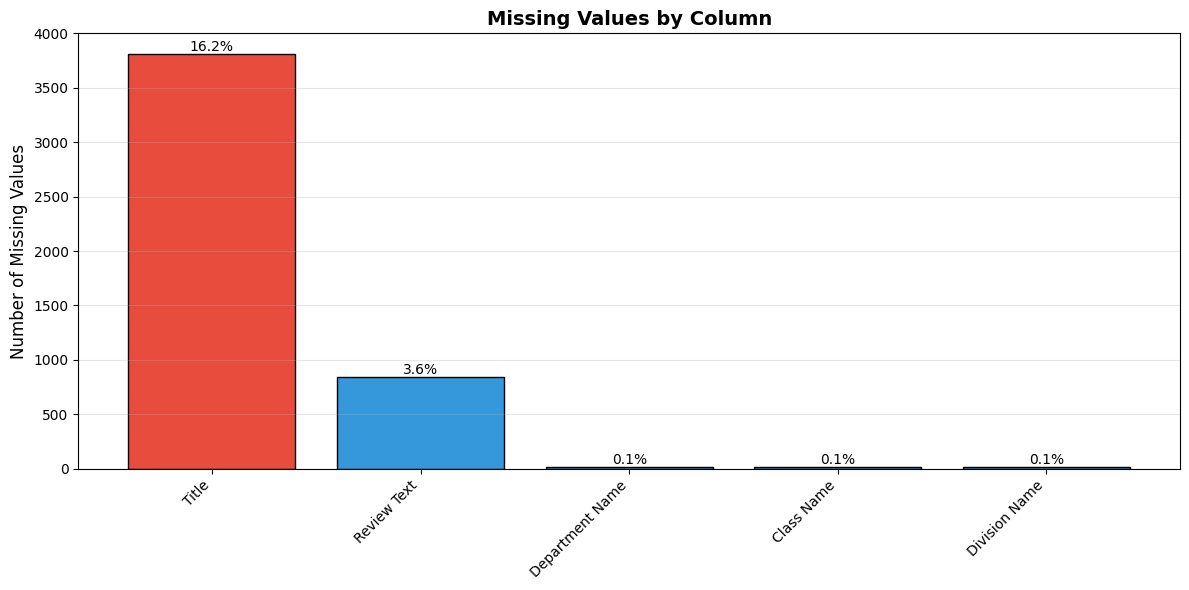

In [99]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

if len(missing_data) > 0:
    colors = ['#e74c3c' if x > len(df)*0.1 else '#f39c12' if x > len(df)*0.05 else '#3498db' 
              for x in missing_data.values]
    
    bars = plt.bar(range(len(missing_data)), missing_data.values, color=colors, edgecolor='black')
    plt.xticks(range(len(missing_data)), missing_data.index, rotation=45, ha='right')
    plt.ylabel('Number of Missing Values', fontsize=12)
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, value) in enumerate(zip(bars, missing_data.values)):
        height = bar.get_height()
        percentage = (value / len(df)) * 100
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{percentage:.1f}%',
                 ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

Suppression des données vides

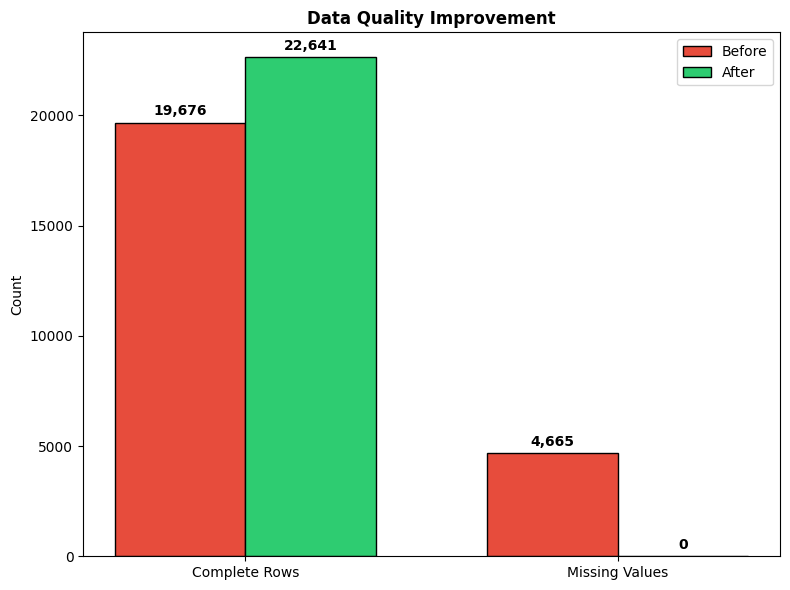

In [100]:
# Remove rows with empty review text
df = df.dropna(subset=['Review Text'])

# Replace empty titles with blank space
df['Title'] = df['Title'].fillna('')

# Find most common values for Division Name, Department Name, and Class Name
most_common_division = df['Division Name'].mode()[0]
most_common_department = df['Department Name'].mode()[0] 
most_common_class = df['Class Name'].mode()[0]

# Fill missing values with most common ones
df['Division Name'] = df['Division Name'].fillna(most_common_division)
df['Department Name'] = df['Department Name'].fillna(most_common_department)
df['Class Name'] = df['Class Name'].fillna(most_common_class)

# 4. Data quality improvement
quality_metrics = ['Complete Rows', 'Missing Values']
before = [19676, 4665]  # Calculated from previous analysis
after = [22641, 0]
x = np.arange(len(quality_metrics))
width = 0.35

# Create figure and axis for the plot
fig, ax4 = plt.subplots(figsize=(8, 6))

bars1 = ax4.bar(x - width/2, before, width, label='Before', color='#e74c3c', edgecolor='black')
bars2 = ax4.bar(x + width/2, after, width, label='After', color='#2ecc71', edgecolor='black')

ax4.set_title('Data Quality Improvement', fontweight='bold')
ax4.set_ylabel('Count')
ax4.set_xticks(x)
ax4.set_xticklabels(quality_metrics)
ax4.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 200,
                f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Suppresion des lignes ou le ranking est égal à 3

In [101]:
# Remove rows with rating = 3
print(f"Dataset shape before removing rating=3: {df.shape}")
print(f"Number of rows with rating=3: {(df['Rating'] == 3).sum()}")

df = df[df['Rating'] != 3]

print(f"Dataset shape after removing rating=3: {df.shape}")
print(f"Rows removed: {22641 - df.shape[0]}")

Dataset shape before removing rating=3: (22641, 11)
Number of rows with rating=3: 2823
Dataset shape after removing rating=3: (19818, 11)
Rows removed: 2823


## Ajout de la classe de résultat : 1 if the client is happy, 0 if he's not

In [102]:
# Add a new column 'result' based on rating
# 1 if rating > 3 (satisfied customer), 0 if rating < 3 (unsatisfied customer)
df['result'] = (df['Rating'] > 3).astype(int)

# Display the distribution of the new result column
print("=== RESULT COLUMN DISTRIBUTION ===")
result_counts = df['result'].value_counts().sort_index()
print(result_counts)

=== RESULT COLUMN DISTRIBUTION ===
result
0     2370
1    17448
Name: count, dtype: int64


On remarque qu'il y a beaucoup plus de valeur positive que negative, il faudra normaliser les valeurs pouréviter les erreurs

## Suppression dse colonnes inutiles


In [103]:
# Remove columns that are not useful for prediction
columns_to_remove = ['Unnamed: 0', 'Clothing ID', 'Age']

print(f"Columns to remove: {columns_to_remove}")

df = df.drop(columns=columns_to_remove)

print(f"Remaining columns: {list(df.columns)}")

Columns to remove: ['Unnamed: 0', 'Clothing ID', 'Age']
Remaining columns: ['Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name', 'result']


## Harmonisation des valeurs et données

In [104]:
# Text cleaning function with stop words removal
common_stop_words = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
    'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them',
    'my', 'your', 'his', 'her', 'its', 'our', 'their',
    'this', 'that', 'these', 'those',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must',
    'not', 'yes', 'so',
    'up', 'down', 'out', 'off', 'over', 'again', 'further', 'then', 'once'
}

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stop words
    words = text.split()
    words = [word for word in words if word not in common_stop_words]
    text = ' '.join(words)
    return text

# Clean and combine text
df['Review Text'] = df['Review Text'].apply(clean_text)
df['Title'] = df['Title'].apply(clean_text)
df['Combined Text'] = (df['Title'] + ' ' + df['Review Text']).str.strip()

In [105]:
# Encode categorical variables
le_division = LabelEncoder()
le_department = LabelEncoder()
le_class = LabelEncoder()

df['Division Name Encoded'] = le_division.fit_transform(df['Division Name'])
df['Department Name Encoded'] = le_department.fit_transform(df['Department Name'])
df['Class Name Encoded'] = le_class.fit_transform(df['Class Name'])

In [106]:
# Display sample
print(f"Total samples: {len(df):,}")
print(f"Positive: {df['result'].sum():,} ({df['result'].mean():.1%})")
print(f"Negative: {(df['result'] == 0).sum():,} ({(df['result'] == 0).mean():.1%})")

df[['Combined Text', 'Division Name Encoded', 'Positive Feedback Count', 'Rating', 'result']].head()

Total samples: 19,818
Positive: 17,448 (88.0%)
Negative: 2,370 (12.0%)


,Combined Text,Division Name Encoded,Positive Feedback Count,Rating,result
0,absolutely wonderful silky sexy comfortable,2,0,4,1
1,love dress sooo pretty happened find store im ...,0,4,5,1
3,favorite buy love love love jumpsuit fun flirt...,1,0,5,1
4,flattering shirt shirt very flattering all due...,0,6,5,1
5,very petite love tracy reese dresses one very ...,0,4,2,0


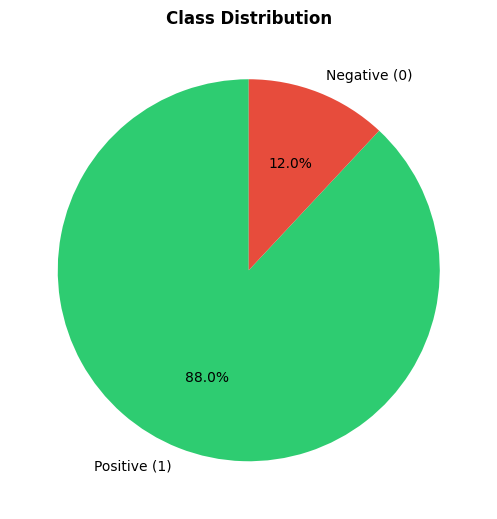

In [107]:
# Check class distribution imbalance
positive_count = df['result'].sum()
negative_count = (df['result'] == 0).sum()

# Correct imbalance ratio (majority:minority)
imbalance_ratio = positive_count / negative_count

# Visualize the class distribution
plt.figure(figsize=(10, 6))

# Pie chart
plt.subplot(1, 2, 1)
counts = df['result'].value_counts()
colors = ['#2ecc71', '#e74c3c']
labels = ['Positive (1)', 'Negative (0)']
plt.pie(counts.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution', fontweight='bold')


plt.tight_layout()
plt.show()
